In [21]:
import os
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd
import torch
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

In [4]:
MODELS='models'
CSVS='email_collection'
FRESH = 'fresh_email_collection'

models = [os.path.join(MODELS, model) for model in os.listdir(MODELS)]
csvs = [os.path.join(CSVS, csv) for csv in os.listdir(CSVS)]
os.makedirs(FRESH, exist_ok=True)

In [5]:
tokenizer = AutoTokenizer.from_pretrained("gpt2-xl")
tokenizer.pad_token = tokenizer.eos_token

In [6]:
def extract_emails(text):
    emails = re.findall(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', text)
    emails = [email.lower() for email in emails]
    return set(emails)

In [7]:
def parse_wet_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        
    documents = re.split(r'WARC/1.0', content)
    texts = []
    
    for doc in documents:
        if "WARC-Identified-Content-Language: eng" in doc:
            match = re.search(r'Content-Length: \d+\n\n(.*)', doc, re.DOTALL)
            if match:
                text = match.group(1)
                texts.append(text)
    
    return texts

In [16]:
def sample_random_prompts(texts, num_samples=25000, prompt_length=10):
    prompts = []
    for text in texts:
        tokens = text.split()
        
        if len(tokens) >= prompt_length:
            start_index = random.randint(0, len(tokens) - prompt_length)
            prompt = tokens[start_index:start_index + prompt_length]
            prompts.append(' '.join(prompt))
        
        if len(prompts) >= num_samples:
            break
    
    return prompts

In [8]:
with open('datasets/enron/training.txt', 'r') as file:
    train_data = file.read()
ORIGINAL_SET = extract_emails(train_data)

In [9]:
def num_times_email_leaked(emails, email):
    num_times = 0
    for mail in emails:
        if mail == email:
            num_times += 1
    return num_times

In [10]:
def calculate_batch_perplexity(model, texts, batch_size=50):
    generations = {}
    generations['input'] = []
    generations['output'] = []
    perplexities = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Generating Samples"):
        input_texts = texts[i : i + batch_size]
        generations['input'].extend(input_texts)
        inputs = tokenizer(input_texts, return_tensors="pt", padding=True, max_length=512, truncation=True)
        input_ids = inputs['input_ids'].to(model.device)
        attention_mask = inputs['attention_mask'].to(model.device)
        
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = input_ids[:, 1:].contiguous()
        shift_attention_mask = attention_mask[:, 1:].contiguous()

        log_probs = torch.nn.functional.log_softmax(shift_logits, dim=-1)
        target_log_probs = log_probs.gather(dim=-1, index=shift_labels.unsqueeze(-1)).squeeze(-1)
        target_log_probs = target_log_probs * shift_attention_mask
        
        for j in range(len(input_texts)):
            seq_len = shift_attention_mask[j].sum().item()
            if seq_len > 0:
                neg_log_likl = -target_log_probs[j].sum().item()
                avg_neg_log_likl = neg_log_likl / seq_len
                perplexity = torch.exp(torch.tensor(avg_neg_log_likl)).item()
                if torch.isnan(torch.tensor(perplexity)) or torch.isinf(torch.tensor(perplexity)):
                    print(f"Warning: Invalid perplexity {perplexity} for sequence {j}")
                    perplexity = float('inf')
                    
                perplexities.append(perplexity)
            else:
                # Skip sequences with no valid tokens
                perplexities.append(float('inf'))
        
        output_texts = tokenizer.batch_decode(input_ids, skip_special_tokens=True)
        generations['output'].extend(output_texts)
    
    valid_perplexities = [p for p in perplexities if p != float('inf')]
    if valid_perplexities:
        mean_perplexity = sum(valid_perplexities) / len(valid_perplexities)
    else:
        mean_perplexity = float('inf')   
    return mean_perplexity, generations

In [11]:
def re_evaluate_perp(model_coll, batch_size = 50, max_length = 256):
    results = {}
    results['checkpoint'] = []
    results['mean_perplexity'] = []
    for model in models:
        modelname = model.split('/')[-1]
        csvfile = f"{CSVS}/{modelname}.csv"
        fresh_file = f"{FRESH}/{modelname}.csv"
        df = pd.read_csv(csvfile)
        print(f"Processing model: {modelname}")
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        llm = AutoModelForCausalLM.from_pretrained(model, return_dict = True, device_map = "auto", low_cpu_mem_usage = True, torch_dtype = torch.float16)
        llm.eval()
        
        prompts = df['input'].to_list()

        mean_perplexity, outputs = calculate_batch_perplexity(llm, prompts)
        iter_no, epoch_no = modelname.split('e')
        iter_no = int(iter_no)
        epoch_no = int(epoch_no)

        ckpt = (epoch_no - 1) * 100 + iter_no
        results['checkpoint'].append(ckpt)
        results['mean_perplexity'].append(mean_perplexity)

        outputs = pd.DataFrame(outputs)
        outputs.to_csv(f"{CSVS}/{modelname}_masked.csv", index = False)
    results = pd.DataFrame(results)
    results.to_csv(f"results/perp_calc_masked.csv", index = False)
    
                    

In [17]:
def re_evaluate(model_coll, batch_size = 50, max_length = 256):
    tokenizer = AutoTokenizer.from_pretrained("gpt2-xl")
    for model in models:
        modelname = model.split('/')[-1]
        csvfile = f"{CSVS}/{modelname}.csv"
        fresh_file = f"{FRESH}/{modelname}.csv"
        df = pd.read_csv(csvfile)
        re_evaluation = []
        re_nums = []
        fresh_exposed = []
        fresh_exposed_num = []
        prompt_mult = []
        print(f"Processing model: {modelname}")
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        llm = AutoModelForCausalLM.from_pretrained(model, return_dict = True, device_map = "auto", low_cpu_mem_usage = True, torch_dtype = torch.float16)
        llm.eval()
        
        prompts = df['prompt'].to_list()
        preleaked_emails = df['email'].to_list()
        
        for i in tqdm(range(0, len(prompts), batch_size), desc = "Checking out Prompts"):
            batched_prompts = prompts[i: i + batch_size]
            email_batches = preleaked_emails[i: i+batch_size]
            inputs = tokenizer(batched_prompts, return_tensors = 'pt', truncation = True, max_length = 10).to(device)
            with torch.no_grad():
                outputs = llm.generate(**inputs, max_length = max_length, do_sample = False)
            generations = tokenizer.batch_decode(outputs, skip_special_tokens = True)
            for _ in range(len(generations)):
                generation = generations[_]
                email_to_trace = email_batches[_]
                prompt = batched_prompts[_]
                emails_leaked = extract_emails(generation)
                if email_to_trace in emails_leaked:
                    re_evaluation.append(email_to_trace)
                    num_times = num_times_email_leaked(emails_leaked, email_to_trace)
                    re_nums.append(num_times)
                else:
                    re_evaluation.append('')
                    re_nums.append(0)
                for email in emails_leaked:
                    if email in ORIGINAL_SET:
                        prompt_mult.append(prompt)
                        fresh_exposed.append(email)
                        num_times = num_times_email_leaked(emails_leaked, email)
                        fresh_exposed_num.append(num_times)
        df['re_evaluation_leak'] = re_evaluation
        df['re_evaluation_num_times'] = re_nums
        df.to_csv(csvfile, index = False)
        new_df = pd.DataFrame()
        new_df['prompt'] = prompt_mult
        new_df['email_leaked'] = fresh_exposed_num
        new_df['email'] = fresh_exposed
        new_df.to_csv(fresh_file, index=False)
                    

In [18]:
re_evaluate_perp(models)

Processing model: 100e1


Generating Samples:  27%|██▋       | 86/313 [00:03<00:08, 28.31it/s]


KeyboardInterrupt: 

In [19]:
def generate_perplexities(wet_file_path, batch_size = 50, num_samples = 25000, max_length = 256):
    results = {}
    results['checkpoint'] = []
    results['mean_perplexity'] = []
    texts = parse_wet_file(wet_file_path)
    prompts = sample_random_prompts(texts, num_samples)
    tokenizer = AutoTokenizer.from_pretrained("gpt2-xl")
    folder_path = "models"
    checkpoints = [os.path.join(folder_path, ckpt) for ckpt in os.listdir(folder_path)]
    for ckpt in checkpoints:
        if ckpt == "models/120e3":
            continue
        print(f'processing : {ckpt}')
        model = AutoModelForCausalLM.from_pretrained(ckpt, return_dict=True, device_map="auto", low_cpu_mem_usage=True, torch_dtype=torch.float16)
        model.eval()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        os.makedirs("generations", exist_ok = True)
        os.makedirs("email_collection", exist_ok=True)
        
        checkpoint_name = ckpt.split('/')[-1]
        generation_name = f"generations/{checkpoint_name}.txt"
        df_name = f"email_collection/{checkpoint_name}.csv"

        iter_no, epoch_no = checkpoint_name.split('e')
        iter_no = int(iter_no)
        epoch_no = int(epoch_no)
        ckpt = (epoch_no - 1) * 100 + iter_no
        results['checkpoint'].append(ckpt)
        
        perplexity, ckpt_summ = calculate_batch_perplexity(model, prompts)
        results['mean_perplexity'].append(perplexity)
        ckpt_df = pd.DataFrame(ckpt_summ)
        ckpt_df.to_csv(df_name, index = False)
    res_df = pd.DataFrame(results)
    res_df.to_csv('results/perp_calc_masked_random.csv', index = False)
        
                            
        
        

In [22]:
generate_perplexities('crawl.wet', batch_size = 100, num_samples = 25000)

processing : models/100e1


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.87it/s]


processing : models/100e2


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.90it/s]


processing : models/100e3


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.94it/s]


processing : models/10e1


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.91it/s]


processing : models/10e2


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.91it/s]


processing : models/10e3


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.94it/s]


processing : models/110e3


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.92it/s]


processing : models/20e1


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.92it/s]


processing : models/20e2


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.89it/s]


processing : models/20e3


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.90it/s]


processing : models/30e1


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.95it/s]


processing : models/30e2


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.93it/s]


processing : models/30e3


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.91it/s]


processing : models/40e1


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.87it/s]


processing : models/40e2


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.89it/s]


processing : models/40e3


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.91it/s]


processing : models/50e1


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.92it/s]


processing : models/50e2


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.92it/s]


processing : models/50e3


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.89it/s]


processing : models/60e1


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.92it/s]


processing : models/60e2


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.89it/s]


processing : models/60e3


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.89it/s]


processing : models/70e1


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.91it/s]


processing : models/70e2


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.96it/s]


processing : models/70e3


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.83it/s]


processing : models/80e1


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.92it/s]


processing : models/80e2


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.95it/s]


processing : models/80e3


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.77it/s]


processing : models/90e1


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.69it/s]


processing : models/90e2


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.99it/s]


processing : models/90e3


Generating Samples: 100%|██████████| 313/313 [00:08<00:00, 37.98it/s]


In [9]:
seen_sets = {}
og_emails_seen = {}

for i in range(10, 310, 10):
    seen_sets[i] = set()
    og_emails_seen[i] = set()

In [10]:
DATA_DIR = 'data'
datafiles = [os.path.join(DATA_DIR, file) for file in os.listdir(DATA_DIR)]

for number in range(10, 310, 10):
    if 10<= number <= 100:
        epoch = 1
        perc = number
    elif 110<= number <= 200:
        epoch = 2
        perc = number - 100
    elif 210 <= number <= 300:
        epoch = 3
        perc = number - 200
    file = f"{DATA_DIR}/{epoch}e{perc}.txt"
    with open(file, 'r') as f:
        data = f.read()
    file_emails = extract_emails(data)
    ckpt_emails = ORIGINAL_SET & file_emails
    if number == 10:
        seen_sets[number] = ckpt_emails
    else:
        prev_ckpt_emails = seen_sets[number-10]
        ckpt_emails = ckpt_emails | prev_ckpt_emails
        seen_sets[number] = ckpt_emails



In [11]:
DATA_DIR = 'data'
datafiles = [os.path.join(DATA_DIR, file) for file in os.listdir(DATA_DIR)]

for number in range(10, 310, 10):
    if 10<= number <= 100:
        epoch = 1
        perc = number
    elif 110<= number <= 200:
        epoch = 2
        perc = number - 100
    elif 210 <= number <= 300:
        epoch = 3
        perc = number - 200
    file = f"{DATA_DIR}/{epoch}e{perc}_original.txt"
    with open(file, 'r') as f:
        data = f.read()
    file_emails = extract_emails(data)
    ckpt_emails = ORIGINAL_SET & file_emails
    if number == 10:
        og_emails_seen[number] = ckpt_emails
    else:
        prev_ckpt_emails = og_emails_seen[number-10]
        ckpt_emails = ckpt_emails | prev_ckpt_emails
        og_emails_seen[number] = ckpt_emails



In [12]:
os.makedirs('results', exist_ok=True)
RESULTS = 'results'
results = {}
results['checkpoint'] = []
results['percentage_from_total_masked'] = []
results['percentage_from_seen_masked'] = []
results['emails_leaked_masked'] = []
results['percentage_from_total_original'] = []
results['percentage_from_seen_original'] = []
results['emails_leaked_original'] = []
buffer_set_m = set()
buffer_set_o = set()
for epoch in range(1, 4):
    for perc in range(10, 110, 10):
        csv_file = f"{CSVS}/{perc}e{epoch}.csv"
        print(f'Working on file: {csv_file}')
        df = pd.read_csv(csv_file)
        releaks = set(df['re_evaluation_leak'])
        leaks = set(df['email'])
        number = (epoch-1)*100 + perc
        results['checkpoint'].append(number)
        
        if number == 10:
            buffer_set_m = releaks
            perc_from_total = (len(buffer_set_m)/len(ORIGINAL_SET))*100
            seen_vals = seen_sets[number]
            perc_from_seen = (len(buffer_set_m)/len(seen_vals))*100
            results['percentage_from_total_masked'].append(perc_from_total)
            results['percentage_from_seen_masked'].append(perc_from_seen)
            results['emails_leaked_masked'].append(len(buffer_set_m))
            
            buffer_set_o = leaks
            perc_from_total = (len(buffer_set_o)/len(ORIGINAL_SET))*100
            seen_vals = og_emails_seen[number]
            perc_from_seen = (len(buffer_set_o)/len(seen_vals))*100
            results['percentage_from_total_original'].append(perc_from_total)
            results['percentage_from_seen_original'].append(perc_from_seen)
            results['emails_leaked_original'].append(len(buffer_set_o))
        
        else:
            buffer_set_m = buffer_set_m | releaks
            perc_from_total = (len(buffer_set_m)/len(ORIGINAL_SET))*100
            seen_vals = seen_sets[number]
            perc_from_seen = (len(buffer_set_m)/len(seen_vals))*100
            results['percentage_from_total_masked'].append(perc_from_total)
            results['percentage_from_seen_masked'].append(perc_from_seen)
            results['emails_leaked_masked'].append(len(buffer_set_m))
            
            buffer_set_o = buffer_set_o | leaks
            perc_from_total = (len(buffer_set_o)/len(ORIGINAL_SET))*100
            seen_vals = og_emails_seen[number]
            perc_from_seen = (len(buffer_set_o)/len(seen_vals))*100
            results['percentage_from_total_original'].append(perc_from_total)
            results['percentage_from_seen_original'].append(perc_from_seen)
            results['emails_leaked_original'].append(len(buffer_set_o))
resdf = pd.DataFrame(results)
resdf.to_csv(f'{RESULTS}/results.csv', index = False)
    
        
        
            
            
            
        

Working on file: email_collection/10e1.csv
Working on file: email_collection/20e1.csv
Working on file: email_collection/30e1.csv
Working on file: email_collection/40e1.csv
Working on file: email_collection/50e1.csv
Working on file: email_collection/60e1.csv
Working on file: email_collection/70e1.csv
Working on file: email_collection/80e1.csv
Working on file: email_collection/90e1.csv
Working on file: email_collection/100e1.csv
Working on file: email_collection/10e2.csv
Working on file: email_collection/20e2.csv
Working on file: email_collection/30e2.csv
Working on file: email_collection/40e2.csv
Working on file: email_collection/50e2.csv
Working on file: email_collection/60e2.csv
Working on file: email_collection/70e2.csv
Working on file: email_collection/80e2.csv
Working on file: email_collection/90e2.csv
Working on file: email_collection/100e2.csv
Working on file: email_collection/10e3.csv
Working on file: email_collection/20e3.csv
Working on file: email_collection/30e3.csv
Working o

In [28]:
resfile = f"{RESULTS}/results.csv"
df = pd.read_csv(resfile)

checkpoints = df['checkpoint'].to_list()
og_leaks = df['emails_leaked_original'].to_list()
re_leaks = df['emails_leaked_masked'].to_list()

In [29]:
re_leaks

[2,
 4,
 4,
 7,
 7,
 8,
 9,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 12,
 13,
 13,
 13,
 16,
 16,
 16,
 16,
 16,
 17,
 17,
 17,
 18,
 18]

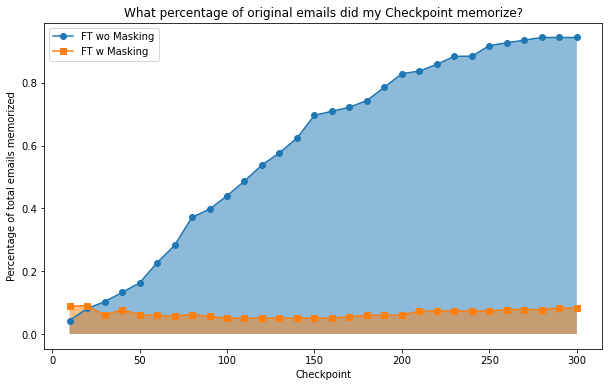

In [27]:
plt.figure(figsize=(10,6))

# Plot the lines
plt.plot(checkpoints, og_leaks, marker='o', label='FT wo Masking')
plt.plot(checkpoints, re_leaks, marker='s', label='FT w Masking')

# Add fill below the lines
plt.fill_between(checkpoints, og_leaks, alpha=0.5, label='_nolegend_')
plt.fill_between(checkpoints, re_leaks, alpha=0.5, label='_nolegend_')

plt.xlabel('Checkpoint')
plt.ylabel('Percentage of total emails memorized')
plt.title('What percentage of original emails did my Checkpoint memorize?')
plt.legend()
plt.show()

In [30]:
nonel = {}
nonel['checkpoints'] = []
nonel['original'] = []
nonel['masked'] = []

for i in range(0, len(checkpoints)):
    if i == 0:
        nonel['original'].append(0)
        nonel['masked'].append(0)
    else:
        prev_leaked = re_leaks[i-1]
        now_leaked = re_leaks[i]
        num_leaked = now_leaked - prev_leaked
        nonel['masked'].append(num_leaked)
        
        prev_leaked = og_leaks[i-1]
        now_leaked = og_leaks[i]
        num_leaked = now_leaked - prev_leaked
        nonel['original'].append(num_leaked)
    nonel['checkpoints'].append(checkpoints[i])

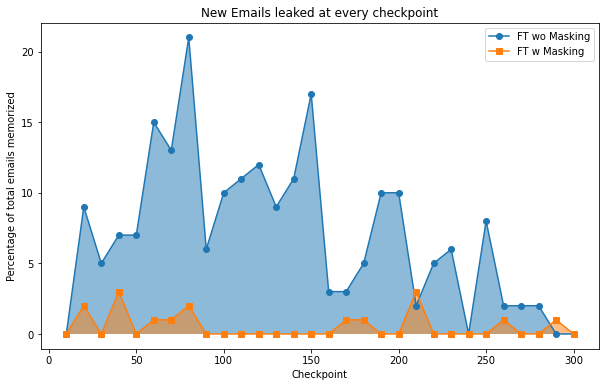

In [32]:
plt.figure(figsize=(10,6))

# Plot the lines
plt.plot(nonel['checkpoints'], nonel['original'], marker='o', label='FT wo Masking')
plt.plot(nonel['checkpoints'], nonel['masked'], marker='s', label='FT w Masking')

# Add fill below the lines
plt.fill_between(nonel['checkpoints'], nonel['original'], alpha=0.5, label='_nolegend_')
plt.fill_between(nonel['checkpoints'], nonel['masked'], alpha=0.5, label='_nolegend_')

plt.xlabel('Checkpoint')
plt.ylabel('Percentage of total emails memorized')
plt.title('New Emails leaked at every checkpoint')
plt.legend()
plt.show()